## What is the goal of this project?

#### The school world contains so much data and yet barely any schools are taking advantage of it.
#### Their administrators don't have the time to dig deep into the data and pull out information
#### This project will act almost as a POC to a potential plugin/dashboard that schools can enter into their Student Information Systems where administrators can quickly yield results that will help guide them to action

#### Some questions that we will be exploring: Can we predict the ELA (English Language Acquisition) status/level of a student based on their grade? What about their current english grade based on the previous 2 years of English test grades? Taking a mixed effect model and looking at differences. 
#### There are many more questions we can ask of the data, but for our current scope, we will focus on these 3.

In [172]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
%matplotlib inline

In [41]:
# Loading the data in long format (each respondent has one row per response)
data=pd.read_csv('Report.csv')
#elaDummies = pd.get_dummies(data["ca_elastatus"])
#data = data.append(elaDummies)
print(data.shape)
print(data.columns)

(1478, 18)
Index(['student_number', 'grade_level', 'ca_elastatus', 'Race', 'Zip', 'E1',
       'E2', 'E3', 'M1', 'M2', 'M3', 'Days Attended', 'Days Absent 2018-2019',
       'Days Enrolled 2018-2019', 'Attendance Rate 2018-2019',
       'Absent Rate 2018-2019', 'Current English Grade', 'Current Math Grade'],
      dtype='object')


### Data cleanup and converting non-numerical fields to numeric

In [136]:
#I'm not exactly happy with this as we're essentially giving students 0 for missing data, but we have to start somewhere
#I might run another dataset dropping them and looking at the difference.
data= data.fillna(0)

In [137]:
#This is going to take our grades that are in letters and convert them to numbers
#We're not going to worry too much about the + and - even though they have a slight difference, we will group them
def conditions(x):
    if (x == 'A' or x == 'A-'):
        return 1
    elif (x == 'B' or x == 'B+' or x == 'B-'):
        return 2
    elif (x == 'C' or x == 'C+' or x == 'C-'):
        return 3
    elif (x == 'D' or x == 'D-' or x == 'D+'):
        return 4
    elif (x == 'F'):
        return 5
    else:
        return 0

func = np.vectorize(conditions)
#do it for english grades
EngGradeDummies = func(data["Current English Grade"])
data["CurEngGrade"] = EngGradeDummies

#math
MathGradeDummies = func(data["Current Math Grade"])
data["CurMathGrade"] = MathGradeDummies

In [138]:
#this function will take our ELA status and convert them to numbers
def conditionsEla(x):
    if x == 'EO':
        return 1
    elif x == 'EL':
        return 2
    elif x == 'IFEP':
        return 3
    elif x == 'RFEP':
        return 4
    

func = np.vectorize(conditionsEla)
elaDummies = func(data["ca_elastatus"])
data["elastatus"] = elaDummies

In [139]:
#OHE for race
#race = pd.get_dummies(data["Race"], )
#data = data.append(race)
#data = data.fillna(0)


In [140]:
data.columns

Index(['student_number', 'grade_level', 'ca_elastatus', 'Race', 'Zip', 'E1',
       'E2', 'E3', 'M1', 'M2', 'M3', 'Days Attended', 'Days Absent 2018-2019',
       'Days Enrolled 2018-2019', 'Attendance Rate 2018-2019',
       'Absent Rate 2018-2019', 'Current English Grade', 'Current Math Grade',
       'CurEngGrade', 'CurMathGrade', 'elastatus', 'absentrate'],
      dtype='object')

In [141]:
#"Black or African American", 
    #     "Cambodian", "Chinese", "Filipino", "Hispanic", "Multi", "Other Pac Islander", "White"

In [185]:
data["absentrate"] = data["Days Absent 2018-2019"]
#create our X variable
mainSet = data[["grade_level", "absentrate", "E1", "E2", 'E3'
         , "M1", "M2", "M3", "Zip", "CurEngGrade", "CurMathGrade", "elastatus" ]]

 
#X = mainSet.drop("E1", axis=1)
X = mainSet[["E1","E2", "E3", "absentrate", "elastatus", "CurEngGrade"]]
X["E2_Sq"] = mainSet["E2"] ** 2
X["E3_Sq"] = mainSet["E3"] ** 2
#X["CurEngGrade_Sq"] = mainSet["CurEngGrade"] ** 2
X["absentrate_Sq"] = mainSet["absentrate"] ** 2
X["elastatus_Sq"] = mainSet["elastatus"] ** 2

X["inDanger"] = np.where(mainSet["CurEngGrade"] >= 4, 1, 0).astype('int')
y = X["E1"]
X = X.drop("E1", axis=1)

X = (X - X.mean()) / (X.max() - X.min())

#from sklearn.decomposition import PCA


#X_pca = pca.fit_transform(X)

c:\users\sakok\miniconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
c:\users\sakok\miniconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
c:\users\sakok\miniconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [186]:
X.head()

,E2,E3,absentrate,elastatus,CurEngGrade,E2_Sq,E3_Sq,absentrate_Sq,elastatus_Sq,inDanger
6,-0.153638,0.023994,0.115050,-0.369453,-0.234056,-0.172697,-0.04702,0.025202,-0.331682,-0.165635
8,0.346362,0.273994,-0.094627,0.630547,-0.034056,0.327303,0.26548,-0.018763,0.668318,-0.165635
10,-0.403638,-0.476006,-0.094627,-0.036120,0.165944,-0.235197,-0.29702,-0.018763,-0.131682,-0.165635
13,-0.153638,-0.226006,0.018276,-0.036120,-0.234056,-0.172697,-0.23452,-0.006016,-0.131682,-0.165635
14,-0.153638,0.023994,0.098921,-0.369453,-0.234056,-0.172697,-0.04702,0.018698,-0.331682,-0.165635


In [187]:
#clean up the spaces in some areas
#X["E1"] = np.where(X["E1"] == ' ', 0, X["E1"]).astype("int")

X["E2"] = np.where(X["E2"] == ' ', 0, X["E2"]).astype("int")

X["E3"] = np.where(X["E3"] == ' ', 0, X["E3"]).astype("int")

#X["M1"] = np.where(X["M1"] == ' ', 0, X["M1"]).astype("int")

#X["M2"] = np.where(X["M2"] == ' ', 0, X["M2"]).astype("int")

#X["M3"] = np.where(X["M3"] == ' ', 0, X["M3"]).astype("int")

c:\users\sakok\miniconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [188]:
#split the data for analysis
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [189]:
pca = TruncatedSVD(2).fit_transform(X_train, y_train)

### Explore the data 

In [190]:
#explore the data a bit
#sns.(X["inDanger"], X["E2"])


Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.6448705645125704
For n_clusters = 3 The average silhouette_score is : 0.7318191130915542
For n_clusters = 4 The average silhouette_score is : 0.7584118136709442
For n_clusters = 5 The average silhouette_score is : 0.6846530685666334
For n_clusters = 6 The average silhouette_score is : 0.6863694614983846


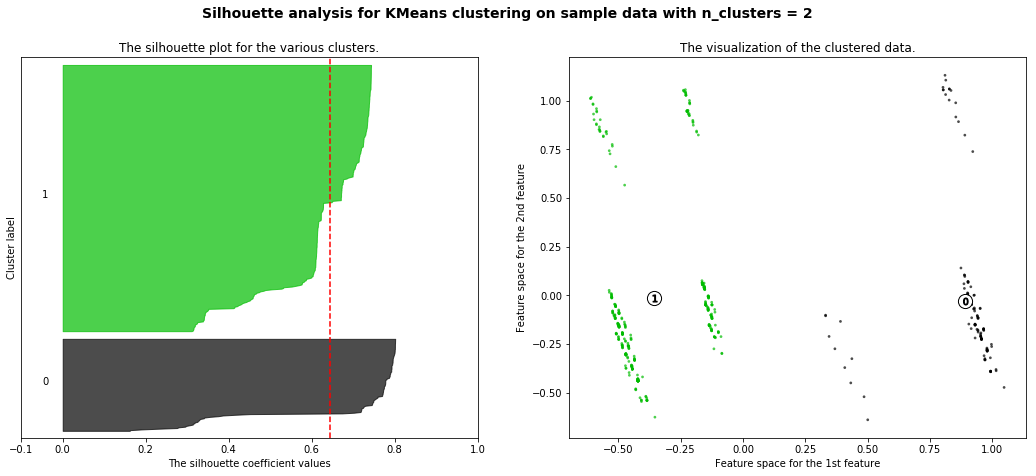

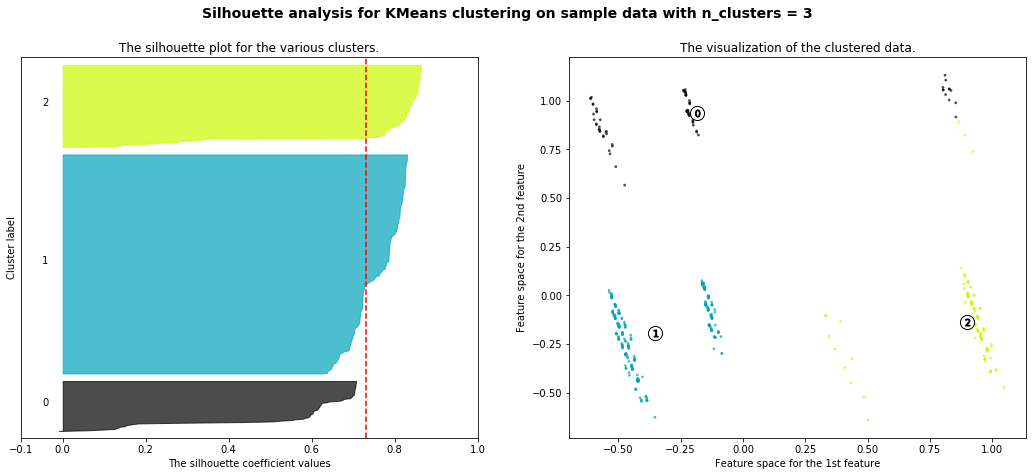

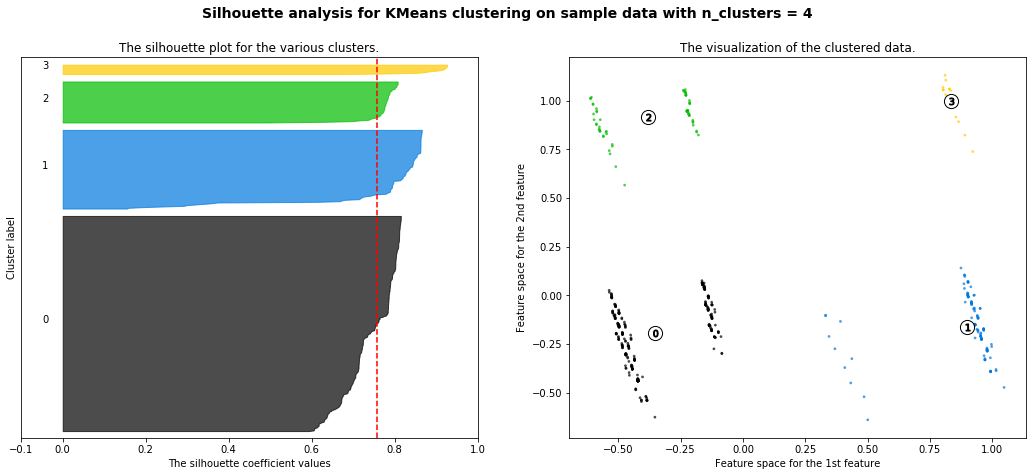

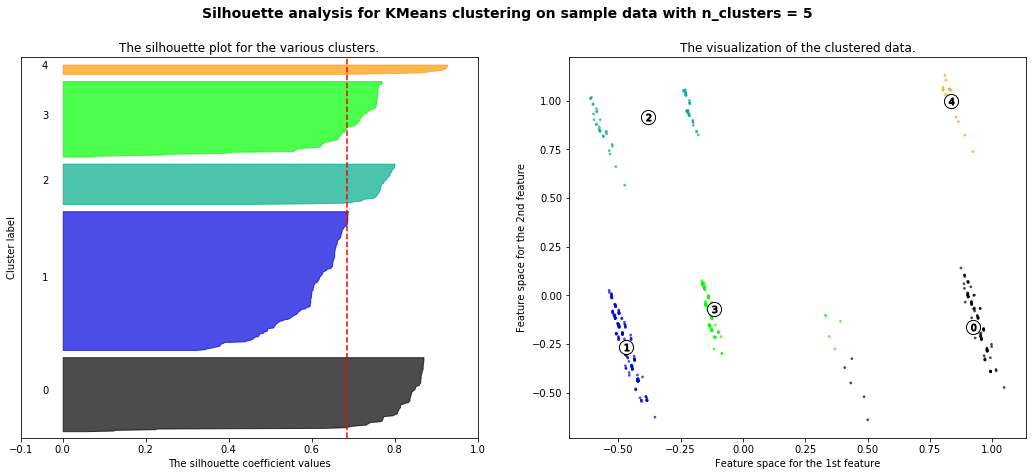

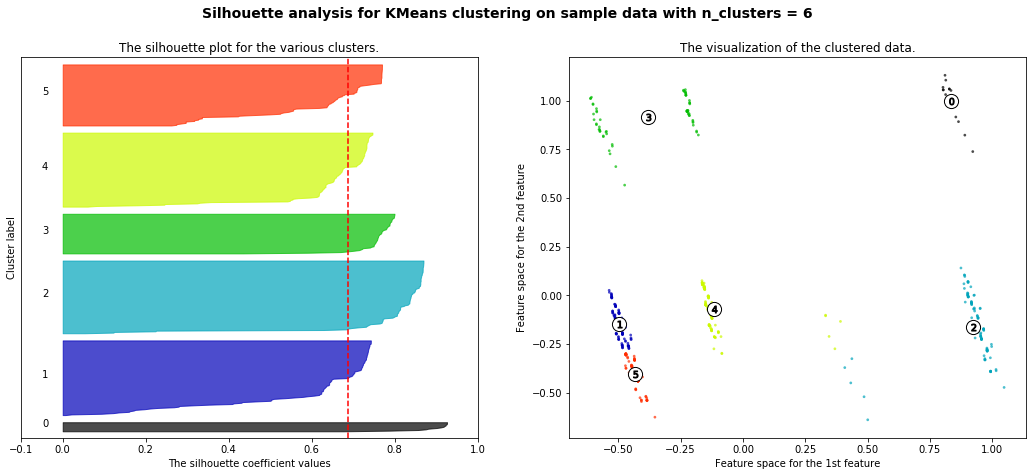

In [191]:
#Let's look at silhouette score

from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X = pca

y = y_pred


# For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

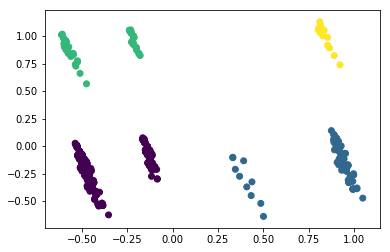

Comparing k-means clusters against the data:
E1      0    1   2   3   4
row_0                     
0      65  122  72  48  14
1       7   43  34  26   8
2      19   31   7   4   1
3       3    5   3   4   0


In [193]:
#I like the 3 clusters
y_pred = KMeans(n_clusters=4).fit_predict(pca)

# Plot the solution.
plt.scatter(pca[:, 0], pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y_train))

### There is a lot of categorical data
#### Some of it is due to converting the grades and ELA status to OHE

In [194]:
summary = y.describe()
summary = summary.transpose()
summary

AttributeError: 'numpy.ndarray' object has no attribute 'describe'

In [195]:
#for x1 in X:
   # sns.distplot(X[x1])
   # plt.show()

In [196]:
#The interesting one for me is our distribution of ELA status at the bottom. 

## ELA Status of a student based on their English grades

In [197]:
#will start with a logistic regression as this is a classification problem

In [200]:
# Declare a logistic regression classifier.
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble

#lr = ensemble.GradientBoostingClassifier(subsample=.2, n_estimators=300, max_features=2)
lr = LogisticRegression()
# Fit the model.
lr.fit(X_train, y_train)

# Display.
print('Coefficients')
print(lr.coef_)

#print(lr.intercept_)
pred_y = lr.predict(X_test)

print('\n Accuracy by ela status')
print(pd.crosstab(pred_y, y_test))

print('\n Percentage accuracy')
print(lr.score(X_train, y_train))

print("Cross Val Score")
print(cross_val_score(lr,X_test,y_test,cv=10))

Coefficients
[[ 0.          0.         -0.43185866  0.57976108 -0.9500891  -4.47122776
  -3.39555596  0.25954809 -0.85975636  0.67725019]
 [ 0.          0.          0.28835852  0.10547781  1.04316722 -1.541538
  -0.91899339 -0.21605663  0.21151607 -0.38386657]
 [ 0.          0.         -0.317416   -0.64179085  0.23664211  0.6112646
   1.12690801 -0.10975336  0.67850431 -0.58144891]
 [ 0.          0.          0.46176325 -0.62371541 -0.48327771  2.53084512
   1.99814049 -0.08075051  0.6283465   0.1696633 ]
 [ 0.          0.          0.00661685 -0.18569677 -0.34962818  2.12027789
   1.6196722   0.04170146 -0.15074703 -0.27454624]]

 Accuracy by ela status
E1      0   1   2   3  4
row_0                   
0       7   0   0   0  0
1      17  43  25   2  1
2       0   0   6   3  1
3       1   0   7  13  4

 Percentage accuracy
0.5116279069767442
Cross Val Score
[0.4        0.4        0.4        0.35714286 0.28571429 0.38461538
 0.41666667 0.5        0.8        0.5       ]


c:\users\sakok\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\linear_model

In [201]:
print(metrics.classification_report(y_test,pred_y))

              precision    recall  f1-score   support

           0       1.00      0.28      0.44        25
           1       0.49      1.00      0.66        43
           2       0.60      0.16      0.25        38
           3       0.52      0.72      0.60        18
           4       0.00      0.00      0.00         6

   micro avg       0.53      0.53      0.53       130
   macro avg       0.52      0.43      0.39       130
weighted avg       0.60      0.53      0.46       130



c:\users\sakok\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [202]:
#next we will look at a random forest
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier(n_estimators=200, max_depth=20 )

rfc.fit(X_train,y_train)
pred_rfc = rfc.predict(X_test)

print(rfc.score(X_train,y_train))
print('\n Accuracy by ela status')
print(pd.crosstab(pred_rfc, y_test))

cross_val_score(rfc,X_test, y_test,cv=10)

0.9050387596899225

 Accuracy by ela status
E1      0   1   2  3  4
row_0                  
0      22   3   2  1  0
1       2  33  20  5  0
2       0   6   7  2  3
3       1   0   9  8  3
4       0   1   0  2  0


c:\users\sakok\miniconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


array([0.66666667, 0.6       , 0.66666667, 0.42857143, 0.42857143,
       0.61538462, 0.58333333, 0.41666667, 0.8       , 0.4       ])

In [166]:
print(metrics.classification_report(y_test,pred_rfc))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        16
           1       0.55      0.71      0.62        42
           2       0.33      0.24      0.28        42
           3       0.38      0.45      0.42        22
           4       0.00      0.00      0.00         8

   micro avg       0.49      0.49      0.49       130
   macro avg       0.43      0.46      0.44       130
weighted avg       0.46      0.49      0.47       130



In [132]:
#Linear SVC
from sklearn.svm import LinearSVC
svc = LinearSVC()
svc.fit(X_train, y_train)
#predictions
predsvc = svc.predict(X_test)

print(svc.score(X_train,y_train))
print('\n Accuracy by ela status')
print(pd.crosstab(predsvc, y_test))

cross_val_score(svc,X_test, y_test,cv=10)


c:\users\sakok\miniconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed

0.6298449612403101

 Accuracy by ela status
E1      0   1   2  3  4
row_0                  
0      11   0   0  2  0
1       4  51  22  7  1
2       0   4   0  0  1
3       0   1  10  9  7


c:\users\sakok\miniconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


array([0.4       , 0.4       , 0.35714286, 0.57142857, 0.5       ,
       0.53846154, 0.33333333, 0.25      , 0.36363636, 0.4       ])

In [133]:
print(metrics.classification_report(y_test,predsvc))

              precision    recall  f1-score   support

           0       0.85      0.73      0.79        15
           1       0.60      0.91      0.72        56
           2       0.00      0.00      0.00        32
           3       0.33      0.50      0.40        18
           4       0.00      0.00      0.00         9

   micro avg       0.55      0.55      0.55       130
   macro avg       0.36      0.43      0.38       130
weighted avg       0.40      0.55      0.46       130



c:\users\sakok\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
